## UDP Traceroute Connectivity by Probe

This notebook uses _existing_ RIPE Atlas measurements to determine how many RIPE Atlas probes might have issues with UDP connectivity. The basic methodology is as follows:

- Examine measurement metadata to find UDP traceroutes from many probes, over time (currently measurements ending in 2015, or still ongoing).
- Take latency to target and target reachability information from each sample. For samples where the target is not reached but some hops did respond, take the latest hop.
- Group reachability information by probe, and classify probes by how confident we are UDP is broken on them.

This notebook searches the RIPE atlas measurement metadata archive (available from [ftp.ripe.net](ftp://ftp.ripe.net/atlas/measurements)) for UDP and TCP traceroute measurements, and uses the Atlas API to download measurements and cache them locally.

### Preamble

Set up the environment and define functions we'll use later.

In [1]:
# Some jupyter magic to set up the environment correctly
%load_ext autoreload
%autoreload 2
%matplotlib inline

# thanks for letting me know about your plans but i don't really care
import warnings
warnings.simplefilter(action = "ignore", category = FutureWarning)

# things we need, things to make us go
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import collections
import warnings
import hashlib
import requests
import os.path
import time
import calendar
import itertools
import json

# HDF5 store for stashing parsed things
store = pd.HDFStore('data_cache/udp_traceconn.h5')

##############################################################################
# Trace metadata named tuple, probe to MSM mapping named tuple,
# and generator for extracting these from the all-measurements-fjson.txt file.
##############################################################################

TraceMeta = collections.namedtuple("TraceMeta", 
                ("msm_id", "af", "proto", "target", 
                 "start_epoch", "stop_epoch", "interval", "probes"))

MSMProbeMeta = collections.namedtuple("MSMProbeMeta", ("msm_id", "pid"))

def tm_generator(first_start=0, last_start=calendar.timegm(time.gmtime()), skip_lines = 0):
    current_time = calendar.timegm(time.gmtime())
    
    with open("data_cache/all-measurements-fjson.txt") as fjf:
        for num, line in enumerate(fjf):
            if num < skip_lines:
                continue
            
            mm = json.loads(line)
                
            if (((mm['type']['id'] == 2) or (mm['type']['id'] == 4)) and
                ((mm['status']['id'] == 2) or (mm['status']['id'] == 4)) and
                (('protocol' in mm) or ('proto_tcp' in mm)) and
                (mm['start_time'] >= first_start) and
                (mm['start_time'] < last_start) ):
            
                    if mm['status']['id'] == 4:
                        stop_time = mm['stop_time']
                    else:
                        stop_time = current_time
                    
                    if 'proto_tcp' in mm and mm['proto_tcp']:
                        proto = 'TCP'
                    else:
                        proto = mm['protocol']
                        
                    yield TraceMeta(mm['msm_id'], mm['af'], proto, mm['dst_addr'], 
                                    mm['start_time'], stop_time, mm['interval'],
                                    mm['participant_count'])

def mpm_generator(msm_ids, skip_lines = 0):
    current_time = calendar.timegm(time.gmtime())

    with open("data_cache/all-measurements-fjson.txt") as fjf:
        for num, line in enumerate(fjf):
            if num < skip_lines:
                continue
        
            mm = json.loads(line)
            if (mm['msm_id'] in msm_ids):
                if "probes" in mm:
                    for p in mm["probes"]:
                        yield MSMProbeMeta(mm['msm_id'], p['id'])
                        
def mpm_dataframe(msm_ids, chunksize=1000000):
    # initialize MPM generator
    mpmgen = mpm_generator(msm_ids)
    
    # initialize accumulators
    df = pd.DataFrame([], columns=MSMProbeMeta._fields)
    data = []
    chunk_count = 0
    
    # get individual rows from get_msm
    for mpm in mpmgen:
        data.append(mpm)
        if len(data) >= chunksize:
            df = df.append(pd.DataFrame(data, columns=MSMProbeMeta._fields), ignore_index=True)
            data = []
            print("chunk "+str(chunk_count))
            chunk_count += 1
                    
    # Append final dataframe if non-empty.
    if len(data) > 0:
        df = df.append(pd.DataFrame(data, columns=MSMProbeMeta._fields), ignore_index=True)

    # Close generator (close underlying file)
    mpmgen.close()
    
    # Return dataframe
    return df

##############################################################################
# Probe metadata named tuple and extraction code
##############################################################################
AtlasProbe = collections.namedtuple("AtlasProbe",
           ("pid", "version", "nat", "ip4", "ip6", "asn4", "asn6", "cc", "lat", "lon"))

def extract_atlas_probe(pobj):
    if "address_v4" in pobj:
        ip4 = pobj["address_v4"]
    else:
        ip4 = None

    if "address_v6" in pobj:
        ip6 = pobj["address_v6"]
    else:
        ip6 = None

    if "asn_v4" in pobj:
        asn4 = pobj["asn_v4"]
    else:
        asn4 = None

    if "asn_v6" in pobj:
        asn6 = pobj["asn_v6"]
    else:
        asn6 = None

    if "tags" in pobj:
        if "system-v1" in pobj["tags"]:
            version = 1
        elif "system-v2" in pobj["tags"]:
            version = 2
        elif "system-v3" in pobj["tags"]:
            version = 3
        elif "system-anchor" in pobj["tags"]:
            version = 4
        else:
            version = 0

        nat = "nat" in pobj["tags"]


    return AtlasProbe(pobj["id"], version, nat, ip4, ip6, asn4, asn6,
                      pobj["country_code"], pobj["latitude"], pobj["longitude"])       

def probe_dataframe_from_file(filename="data_cache/all-probes.json"):
    data = []
    
    # make a giant array
    with open(filename) as stream:
        all_probes = json.loads(stream.read())
        for pobj in all_probes["objects"]:
            data.append(extract_atlas_probe(pobj))

    # create a dataframe from it
    df = pd.DataFrame(data, columns=AtlasProbe._fields)
    
    # indexed by probe ID
    df.index = df['pid']
    del(df['pid'])
    
    # stick an aggregation column on there, we'll use it later
    df['n'] = 1
    
    # and return it
    return df

##############################################################################
# MSM retrieval code
##############################################################################

def get_msm(msm_id, gen, cachedir=None, start=None, stop=None):
    """
    Given an MSM, fetch it from the cache or from the RIPE Atlas API.
    Yield each separate result according to the generation function.
    """
    url = "https://atlas.ripe.net/api/v1/measurement/%u/result/" % (msm_id,)

    params = {"format": "json"}
    if start is not None and stop is not None:
        params["start"] = str(start)
        params["stop"] = str(stop)
    
    if cachedir and os.path.isdir(cachedir):
        filepath = os.path.join(cachedir, "measurement", "%u.json" % (msm_id,))

        # download if not present
        if not os.path.isfile(filepath):
            with open(filepath, mode="wb") as file:
                print("Cache miss, retrieving "+url)
                res = requests.get(url, params=params)

                if not res.ok:
                    raise "Atlas measurement API request failed: "+repr(res.json())
                
                file.write(res.content)

        # then read from cache
        with open(filepath) as stream:
            yield from gen(json.loads(stream.read()))

    else:
        # just read from the net
        res = requests.get(url, params=params)
        yield from gen(json.loads(res.content.decode("utf-8")))

##############################################################################
# Connectivity sample named tuple,
# connectivity sample generator for use with get_msm(),
# and dataframe creation function wrapping all of this together
##############################################################################

TCSample = collections.namedtuple("TCSample",
                     ("msm_id","time","af","proto","pid","sip","dip","reached","hop","rtt"))

def gen_tcs(msm_ary):
    for a_res in msm_ary:        
        if a_res['type'] == 'traceroute':
            if ('result' in a_res):
                maxhop = 0
                maxhop_ok = False
                for hop in a_res['result']:
                    if 'result' in hop:
                        for pkt in hop['result']:
                            if 'from' in pkt:
                                maxhop = hop['hop']
                                if pkt['from'] == a_res['dst_addr']:
                                    maxhop_ok = True
                                    if 'rtt' in pkt:
                                        rtt = pkt['rtt']
                                    else:
                                        rtt = -1
                                    yield TCSample(a_res['msm_id'],
                                           int(a_res['timestamp']), a_res['af'], a_res['proto'],
                                           a_res['prb_id'], a_res['src_addr'], a_res['dst_addr'],
                                           True, maxhop, rtt)
                                    break
                if not maxhop_ok:
                    try:
                        yield TCSample(a_res['msm_id'],
                                       int(a_res['timestamp']), a_res['af'], a_res['proto'],
                                       a_res['prb_id'], a_res['src_addr'], a_res['dst_addr'],
                                       False, maxhop, -1)
                    except KeyError:
                        # ignore completely broken results
                        pass

def tcsample_dataframe(msm_ids, cachedir=None, start=None, stop=None, chunksize=1000000):
    """
    Given an iterable of MSMs, create a dataframe of trace connectivity samples.
    """
    
    # initialize accumulators
    adf = pd.DataFrame([], columns=TCSample._fields)
    data = []
    
    # get individual rows from get_msm
    for msm_id in msm_ids:
        for tcs in get_msm(msm_id, gen=gen_tcs, 
                           start=start, stop=stop, 
                           cachedir=cachedir):
            data.append(tcs)
            
            # Append dataframe to dataframe accumulator if chunking.
            if len(data) >= chunksize:
                adf = adf.append(pd.DataFrame(data, columns=TCSample._fields), ignore_index=True)
                data = []
                
    # Append final dataframe if non-empty.
    if len(data) > 0:
        adf = adf.append(pd.DataFrame(data, columns=TCSample._fields), ignore_index=True)

    # Counter column for aggregation
    adf['n'] = 1
    
    return adf

##############################################################################
# Plotting utility function
##############################################################################

def plot_ecdf(a, **kwargs):
    sa = np.sort(a)
    yv = np.arange(len(sa))/float(len(sa))
    plt.plot(sa, yv, **kwargs)

### Step 1b, 2b: store/restore preparsed raw dataframes in HDF

Do this instead of steps 1 and 2 if not reworking parsing and raw dataframs selection. It's silly fast.

In [2]:
## Restore pre-parsed dataframes from the store, and re-split them as necessary
%time tmdf = store['tmdf']
%time tcsdf = store['tcsdf']

CPU times: user 317 ms, sys: 209 ms, total: 526 ms
Wall time: 594 ms
CPU times: user 1.08 s, sys: 536 ms, total: 1.61 s
Wall time: 1.71 s


### Step 1: find MSM ids for UDP traceroutes 

Here we limit ourselves to MSMs run (1) from many probes, to maximize the number of probes we'll see samples from, and (2) ending in 2015 or later, to focus on the recent past. Note that many of these are MSMs we specified ourselves for our TMA paper. Not many people seem to be interested in UDP traceroute.

In [2]:
# get ALL the traceroutes! (takes about five minutes on Forclaz)
tmgen = tm_generator()
%time tmdf = pd.DataFrame([m for m in tmgen], columns=TraceMeta._fields)
tmgen.close() # generator wraps a file, close it.

# estimate sample count
tmdf['samples'] = (tmdf['probes'] * (tmdf['stop_epoch'] - tmdf['start_epoch'])) / tmdf['interval']

# cast timestamps
tmdf['start'] = pd.to_datetime(tmdf['start_epoch'] * 1e9)
tmdf['stop'] = pd.to_datetime(tmdf['stop_epoch'] * 1e9)
tmdf['duration'] = tmdf['stop'] - tmdf['start']

# count msms
tmdf['n'] = 1

# index by msm
tmdf.index = pd.Index(tmdf['msm_id'])
del(tmdf['msm_id'])

# Dump dataframe into the HDF store
store['tmdf'] = tmdf

# exclude all measurements ending before 1 Jan 2015, and split by protocol
tmdf_udp = tmdf[tmdf['proto'] == 'UDP']
tmdf_udp = tmdf_udp[tmdf_udp["stop"] >= "2015-01-01"]
tmdf_tcp = tmdf[tmdf['proto'] == 'TCP']
tmdf_tcp = tmdf_tcp[tmdf_tcp["stop"] >= "2015-01-01"]
tmdf_icmp = tmdf[tmdf['proto'] == 'TCP']
tmdf_icmp = tmdf_icmp[tmdf_icmp["stop"] >= "2015-01-01"]

# find appropriate MSMs
msm_ids = tmdf_udp[tmdf_udp['probes'] >= 64].index.values

CPU times: user 5min 6s, sys: 6.03 s, total: 5min 12s
Wall time: 5min 13s


8436

### Step 2: Retrieve MSMs and parse them into a dataframe

In [4]:
%time tcsdf = tcsample_dataframe(msm_ids, cachedir="data_cache", chunksize=100000)
store['tcsdf'] = tcsdf

CPU times: user 7min, sys: 16.7 s, total: 7min 17s
Wall time: 7min 31s


/usr/local/lib/python3.5/site-packages/IPython/core/interactiveshell.py:3066: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->['proto', 'sip', 'dip', 'reached']]

  exec(code_obj, self.user_global_ns, self.user_ns)


### Step 3: classify probe IDs by UDP reachability 

First, clean the data: drop all samples from MSMs where no traceroute reached the target (target always down), then all samples from probes with less than n=9 samples.

In [3]:
msm_reached_sum = tcsdf.groupby('msm_id')['reached'].sum()
bad_target_msm_ids = msm_reached_sum[msm_reached_sum == 0].index
tcsdf_target_udp_ok = tcsdf[np.logical_not(tcsdf['msm_id'].isin(bad_target_msm_ids))]
pid_sum = tcsdf.groupby('pid')['n'].sum()
low_volume_pids = pid_sum[pid_sum < 9].index
tcsdf_clean = tcsdf_target_udp_ok[np.logical_not(tcsdf_target_udp_ok['pid'].isin(low_volume_pids))]

Headline number: how many probes might block UDP?

In [4]:
reached_by_pid = tcsdf_clean.groupby('pid')['reached'].sum()
print ("%u / %u (%5.3f%%)" % (len(reached_by_pid[reached_by_pid == 0]),
                            len(reached_by_pid),
                            100 * len(reached_by_pid[reached_by_pid == 0]) / len(reached_by_pid)))

82 / 2240 (3.661%)


Which probes are affected?

In [7]:
pdf = probe_dataframe_from_file()
noudp_pids = reached_by_pid[reached_by_pid == 0].index

pdf_tcsdf = pdf.loc[tcsdf_clean['pid'].unique()]
pdf_noudp = pdf.loc[noudp_pids]

In [8]:
# Get all samples from potentially UDP-blocked probes
tcsdf_blocked = tcsdf_clean[tcsdf_clean['pid'].isin(noudp_pids)]

# list of broken probes, 
pdf_noudp = pd.merge(pdf_noudp, pd.DataFrame(data = {"samples": tcsdf_blocked.groupby('pid')["n"].sum(),
                                         "minhop":  tcsdf_blocked.groupby('pid')["hop"].min(),
                                         "maxhop":  tcsdf_blocked.groupby('pid')["hop"].max()}),
                     left_index = True, right_index = True, how="inner")

In [9]:
len(pdf_tcsdf)

2240

Not yet clear how to classify these based on last hop -- but there's definitely a difference between small hop counts and big ones. Look at AS path distances?

### Step 4: remeasure to small set of known-good anchors with TCP and UDP traceroute

See the [probe_udp_traceconn_create](probe_udp_traceconn_create.ipynb) notebook for more. For now, all you need to know is this:

In [10]:
NEW_MSMS = [x for x in range(3354201,3354261)]

### map broken probes (for fun)

In [82]:
# determine brokenness by country
cc_probe_count = pd.DataFrame(data = {'all': pdf_tcsdf.groupby('cc')['n'].sum(),
                                      'no_udp': pdf_noudp.groupby('cc')['n'].sum()} ).fillna(0)   

cc_probe_count['badness'] = cc_probe_count["no_udp"] / cc_probe_count["all"]
cc_probe_count.sort('badness')
cc_probe_count.loc['NG']

all        4
no_udp     0
badness    0
Name: NG, dtype: float64

In [70]:
# map of country codes to shapes
import shapefile
world_sf = shapefile.Reader("data_cache/world/simple")
world_cc = {}
for sr in world_sf.shapeRecords():
    world_cc[sr.record[1]] = sr.shape

KeyError for CW
KeyError for SS


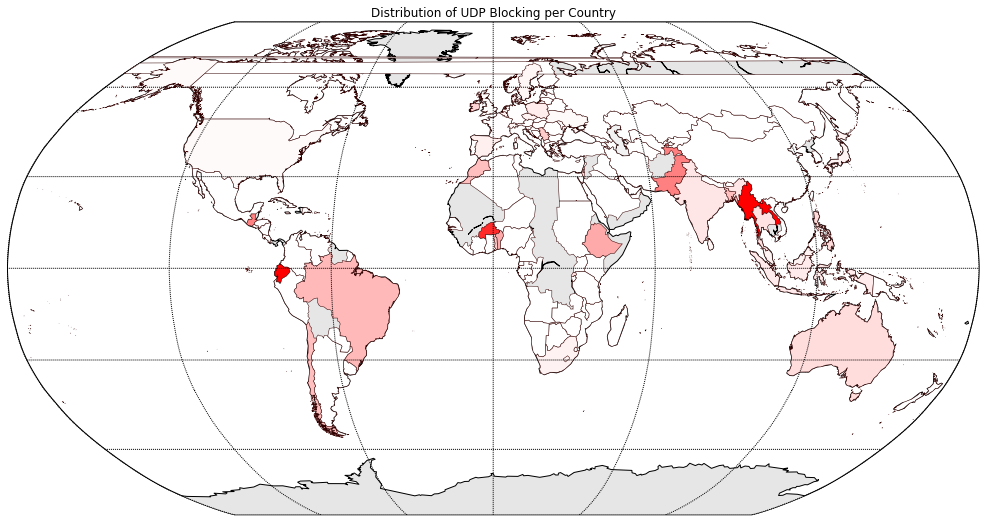

In [80]:
# world map, colored with badness

from mpl_toolkits.basemap import Basemap
from matplotlib.collections import LineCollection

# lon_0 is central longitude of projection.
# resolution = 'c' means use crude resolution coastlines.
plt.figure(figsize=(15,12))
plt.subplots_adjust(left=0.05,right=0.95,top=0.90,bottom=0.05,wspace=0.15,hspace=0.05)
ax = plt.subplot(111)
m = Basemap(projection='robin',lon_0=0,resolution='c')
m.drawcoastlines()
m.fillcontinents(color='0.9', lake_color='0.95')
# draw parallels and meridians.
m.drawparallels(np.arange(-90.,120.,30.))
m.drawmeridians(np.arange(0.,360.,60.))
#x,y = m(pdf_tcsdf['lon'].values,pdf_tcsdf['lat'].values)
#ax.scatter(x,y,alpha=0.1,color="red")

for cc in cc_probe_count.index.values:
    try:
        # set color based on data
        color = (1.0, 1.0 - cc_probe_count.loc[cc]['badness'], 1.0 - cc_probe_count.loc[cc]['badness'])
        
        # now parse the shape into a set of projected line segments
        shape = world_cc[cc]
        polys = [[]]
        for n,p in enumerate(shape.points):
            # Check to see if we have a new polygon
            if n in shape.parts and len(polys[-1]) > 0:
                polys.append([])
            x,y = m(*p)
            polys[-1].append((x,y))
        lines = LineCollection(polys, antialiaseds=(1,))
        lines.set_facecolors(color)
        lines.set_edgecolors((0.2,0,0))
        lines.set_linewidth(.5)
        ax.add_collection(lines)
    except KeyError:
        print("KeyError for "+cc)
        pass
    
#m.drawmapboundary(fill_color='0.95')


plt.title("Distribution of UDP Blocking per Country")
#plt.show()

# Scratch code

Sandbox, dirtpile, etc

In [35]:
len(tcsdf_target_udp_ok.groupby('pid')['reached'].sum())

3763

In [ ]:
plot_ecdf(tcsdf.groupby('pid').reached.sum() / tcsdf.groupby('pid').n.sum())

(0, 32)

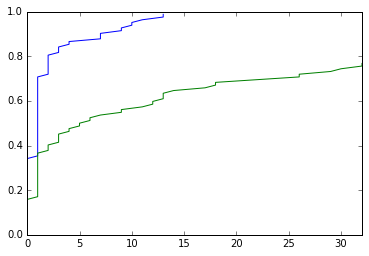

In [15]:
plot_ecdf(pdf_noudp['minhop'])
plot_ecdf(pdf_noudp['maxhop'])
plt.xlim(0,32)

In [ ]:
plot_ecdf(tcsdf[tcsdf['reached']]['hop'])
plot_ecdf(tcsdf[np.logical_not(tcsdf['reached'])]['hop'])

In [77]:
calendar.timegm((2015,1,1,0,0,0))

1420070400

In [212]:
pdf['n'] = 1
pdf_noudp['n'] = 1

In [220]:
as_probe_count = pd.DataFrame(data = {'all': pdf.groupby('asn4')['n'].sum(),
                                      'no_udp': pdf_noudp.groupby('asn4')['n'].sum()} ).dropna()   

In [222]:
cc_probe_count["udp_brokenness"] = cc_probe_count['no_udp'] / cc_probe_count['all']
as_probe_count["udp_brokenness"] = as_probe_count['no_udp'] / as_probe_count['all']

In [223]:
as_probe_count.sort("udp_brokenness")

,all,no_udp,udp_brokenness
asn4,,,
7922,426,2,0.004695
5432,90,1,0.011111
3292,54,1,0.018519
22773,35,1,0.028571
786,33,1,0.030303
38229,24,1,0.041667
7018,48,2,0.041667
4713,20,1,0.050000
1103,19,1,0.052632


In [219]:
cc_probe_count.sort("udp_brokenness")

,all,no_udp,udp_brokenness
DE,1406,1,0.000711
FR,1161,1,0.000861
GB,1063,1,0.000941
NL,804,1,0.001244
CH,351,1,0.002849
CZ,350,1,0.002857
BE,320,1,0.003125
ES,292,1,0.003425
PL,275,1,0.003636
SE,242,1,0.004132


In [ ]:
tcsdf.groupby('probe')